# Creating the MAIZSIM weather file

Load in required packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import xarray as xr
from datetime import datetime
import time 
import datetime as dt

### Reading in and processing met data (NASA ISH)

#### Step 1: create a list with all the weather files to be read
This list is called: weafile_list

#### Step 2: read in all the weather files
Need to parce out relevant info, and store the relevant weather data into individual pd.DataArrays.
The relevant weather data include:
- date/time: need to convert into datetime 64 format
- temperature
- dew temperature
- RH
- precipitaiton


#### Step 3: read in individual weather file lines and parse out the information

In [121]:
##### This loop carries out step 1 - 3:
#---- Reads in weather data from all years & sites, and compiles them into a large pd.DataFrame

### Inputs for looping
years = np.arange(1961,1991) #carefule with python indexing
df_temp_all = pd.DataFrame() # Setting up an empty pd.DataFrame that will store all the information
df_rh_all = pd.DataFrame()
df_precip_all = pd.DataFrame()

### Constants needed for RH calculation
Es_Tref = 6.11 # saturation vapor pressure at reference temperature
Tref = 273.15  # reference temperature
Lv = 2.5e+06   # latent heat of vaporation (J/kg)
Rv = 461       # gas constant for moist air (J/kg)

### Clausius-Clapeyron 
# E = Es_Tref*np.exp((Lv/Rv)*(1/Tref - 1/Temp))*RH
# if RH=1 E = Es
# E: vapor pressure at Temp
# Temp: air temperature (Kelvin)
# RH: relative humidity


### Begin the loop
for i in years:    
    file_list = pd.read_table("/home/disk/eos8/ach315/data/ISH/file_lists/file_list_" + 
                              str(i) + ".csv", squeeze = True, header = None)
    timepoints = pd.date_range(start = str(i) + "-01-01", end = str(i) + "-12-31 23:00:00", freq = "H")
    temp_dataframe = pd.DataFrame(index=timepoints)
    rh_dataframe = pd.DataFrame(index=timepoints)
    precip_dataframe = pd.DataFrame(index=timepoints)

    
    for j in range(0, len(file_list)):
        weafile = pd.read_table("/home/disk/eos8/ach315/data/ISH/" + str(i) + 
                                "/" + file_list[j], header = None, encoding="latin1")
        weadata = weafile.iloc[:,0]
        WBAN_id = file_list[j][7:12] # WBAN site ID
        year = file_list[j][13:17] # year
        time = list()
        temp = list()
        temp_dew = list()
        precip = list()
        precip_hour = list()
        
        
        for k in range(0, len(weadata)):
            timestamp = pd.to_datetime(weadata[k][15:27], format="%Y%m%d%H%M")
            time.append(timestamp)
        
            if int(weadata[k][87:92]) == 9999:
                temp.append("NaN")
            else:
                temp.append(int(weadata[k][87:92])/10)
            
            if int(weadata[k][93:98]) == 9999:
                temp_dew.append("NaN")
            else:
                temp_dew.append(int(weadata[k][93:98])/10)
            
            precip_pos = weadata[k].find("AA1")        
            try: 
                if precip_pos == -1:
                    precip.append("NaN")
                elif int(weadata[k][precip_pos+5:precip_pos+9]) == 9999:
                    precip.append("NaN")
                else:
                    precip.append(int(weadata[k][precip_pos+5:precip_pos+9]))
            except:
                precip.append("NaN")
                print(i, j, k)

        Tair = np.array(temp, dtype = float) + 273
        Tdew = np.array(temp_dew, dtype = float) + 273
        es = Es_Tref*np.exp((Lv/Rv)*(1/Tref - 1/Tair))
        e = Es_Tref*np.exp((Lv/Rv)*(1/Tref - 1/Tdew))
        rh = e/es
        rh = list(rh)
        
        temp_df = pd.DataFrame({WBAN_id: temp}, index= time)
        temp_df = temp_df[~temp_df.index.duplicated()]
        temp_dataframe = pd.concat([temp_dataframe, temp_df], axis= 1, 
                                   join_axes= [temp_dataframe.index])

        rh_df = pd.DataFrame({WBAN_id: rh}, index=time)
        rh_df = rh_df[~rh_df.index.duplicated()]
        rh_dataframe = pd.concat([rh_dataframe, rh_df], axis= 1,
                                 join_axes= [rh_dataframe.index])
        
        precip_df = pd.DataFrame({WBAN_id:precip}, index=time)
        precip_df = precip_df[~precip_df.index.duplicated()]
        precip_dataframe = pd.concat([precip_dataframe, precip_df], axis= 1,
                                    join_axes= [precip_dataframe.index])
        
        
    frames_temp = [df_temp_all, temp_dataframe]
    df_temp_all = pd.concat(frames_temp)
    
    frames_rh = [df_rh_all, rh_dataframe]
    df_rh_all = pd.concat(frames_rh)
    
    frames_precip = [df_precip_all, precip_dataframe]
    df_precip_all = pd.concat(frames_precip)
    
    
    

1973 57 4045
1973 100 2517
1973 143 7699
1974 49 7940
1974 88 3446
1974 139 8729
1975 67 2010
1975 83 9012
1975 126 1354
1976 32 3052
1976 81 1936
1976 172 4039
1977 50 1440
1977 86 2878
1977 161 1561
1977 168 2765
1978 67 3720
1979 61 7718
1979 97 6485
1979 102 1939
1980 45 7102
1980 64 6112
1981 68 4417
1981 68 5333
1983 139 2230


#### Step 4: Output the processed weather data into individual .csv files

In [ ]:
df_temp_all.to_csv("temp_all.csv")
df_precip_all.to_csv("precip_all.csv")
df_rh_all.to_csv("rh_all.csv")

#### Step 5: Read in Solar Radiation Data

In [71]:
file_list = pd.read_table("/home/disk/eos8/ach315/data/ISH_NSRD/file_list_1961to1990.txt",
                          header= None, squeeze= True)
file_list = file_list[7096:]
sites = pd.read_table("/home/disk/eos8/ach315/data/ISH_NSRD/station_list_1961to1990.txt", 
                      header= None, squeeze= True, dtype= str)

for i in file_list:    
    solrad_file = pd.read_table("/home/disk/eos8/ach315/data/ISH_NSRD/1961to1990/" + 
                                str(i), squeeze= True, header= None)
    WBAN_id = i[0:5]
    solrad_all = list()
    timestamp_all = list()   
        
    for j in np.arange(1, len(solrad_file)):
        solrad = solrad_file[j][23:27]
        if solrad == 9999:
            solrad_all.append("NaN")
        else:
            solrad_all.append(solrad)
        
        year = "19" + solrad_file[j][1:3]
        month = solrad_file[j][4:6]
        day = solrad_file[j][7:9]
        hour = solrad_file[j][10:12]
        timestamp = dt.datetime(int(year), int(month), int(day), int(hour)-1) # hour must be in 0-23
        timestamp = pd.to_datetime(timestamp)        
        timestamp_all.append(timestamp)
                    
    df_solrad_all.loc[timestamp_all, WBAN_id] = solrad_all

In [78]:
df_solrad_all.tail()

0                   03103 03812 03813 03820 03822 03856 03860 03870 03927  \
1990-12-31 19:00:00     0     0     0     0     0     0     0     0     0   
1990-12-31 20:00:00     0     0     0     0     0     0     0     0     0   
1990-12-31 21:00:00     0     0     0     0     0     0     0     0     0   
1990-12-31 22:00:00     0     0     0     0     0     0     0     0     0   
1990-12-31 23:00:00  9999  9999  9999  9999  9999  9999  9999  9999  9999   

0                   03928  ...  94746 94814 94822 94823 94830 94846 94847  \
1990-12-31 19:00:00     0  ...      0     0     0     0     0     0     0   
1990-12-31 20:00:00     0  ...      0     0     0     0     0     0     0   
1990-12-31 21:00:00     0  ...      0     0     0     0     0     0     0   
1990-12-31 22:00:00     0  ...      0     0     0     0     0     0     0   
1990-12-31 23:00:00  9999  ...   9999  9999  9999  9999  9999  9999  9999   

0                   94849 94860 94910  
1990-12-31 19:00:00     0     0     0  
1990-12-31 20:00:00     0     0     0  
1990-12-31 21:00:00     0     0     0  
1990-12-31 22:00:00     0     0     0  
1990-12-31 23:00:00  9999  9999  9999  

[5 rows x 237 columns]

In [ ]:
# 190216 notes
# Not sure why but all the last rows are 9999, and they were not converted into NaN
# I double checkted that this only happens in the very last row, but wans't able to fix the code yet.
# for not, here's a hot fix
df_solrad_all.iloc[-1, :] = "NaN"

#### Step 6: Output the processed solar radiation data into .csv file

In [76]:
df_solrad_all.to_csv("solrad_all.csv")

#### Taking a quick look at the weather data across location and time

In [115]:
df_temp_all.loc["1985"].iloc[0:5,0:5]

03103 03812 03813 03820 03822
1985-01-01 00:00:00   2.2  13.3    20  19.4    20
1985-01-01 01:00:00     0  13.3  19.4  18.3  18.9
1985-01-01 02:00:00  -1.1  12.2  18.9  18.9  17.8
1985-01-01 03:00:00  -1.7  13.3  17.8  18.3  17.8
1985-01-01 04:00:00  -2.2  12.8  17.2  17.8  17.8

In [116]:
sites = df_temp_all.columns
timeline = df_temp_all.index

In [210]:
start_time = "1961-05-01 00:00:00"
end_time = "1961-10-31 23:00:00"
df_temp_growseason_1961 = df_temp_all.loc[start_time:end_time]
df_temp_growseason_1961 = df_temp_growseason_1961.astype(float)

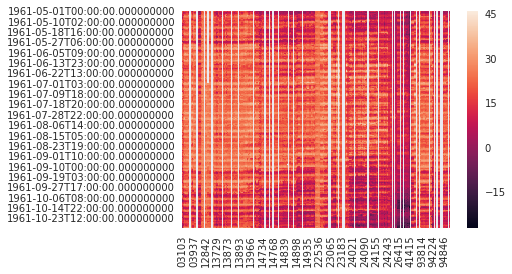

In [211]:
fig, ax = plt.subplots()
sns.heatmap(df_temp_growseason_1961, ax=ax)
fig.savefig("tempdata.eps")

In [ ]:
start_time = "1962-05-01 00:00:00"
end_time = "1962-10-31 23:00:00"
df_temp_growseason_1962 = df_temp_all.loc[start_time:end_time]
df_temp_growseason_1962 = df_temp_growseason_1962.astype(float)
fig, ax = plt.subplots()
sns.heatmap(df_temp_growseason_1962, ax=ax)
#fig.savefig("tempdata_1962.eps")

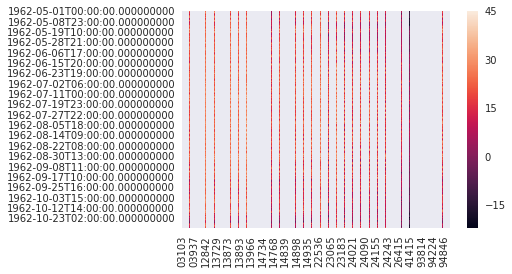

In [215]:
start_time = "1962-05-01 00:00:00"
end_time = "1962-10-31 23:00:00"
df_temp_growseason_1962 = df_temp_all.loc[start_time:end_time]
df_temp_growseason_1962 = df_temp_growseason_1962.astype(float)
fig, ax = plt.subplots()
sns.heatmap(df_temp_growseason_1962, ax=ax)
fig.savefig("tempdata_1962.eps")

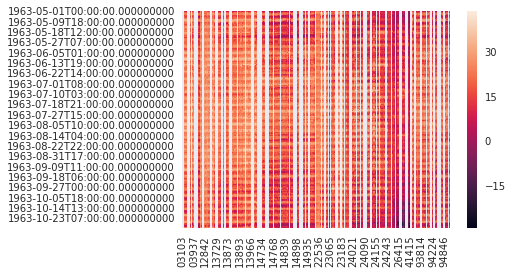

In [216]:
start_time = "1963-05-01 00:00:00"
end_time = "1963-10-31 23:00:00"
df_temp_growseason_1963 = df_temp_all.loc[start_time:end_time]
df_temp_growseason_1963 = df_temp_growseason_1963.astype(float)
fig, ax = plt.subplots()
sns.heatmap(df_temp_growseason_1963, ax=ax)
fig.savefig("tempdata_1963.eps")

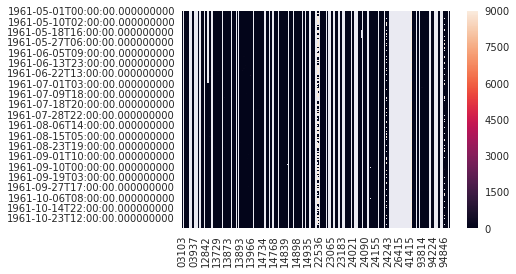

In [217]:
start_time = "1961-05-01 00:00:00"
end_time = "1961-10-31 23:00:00"
df_precip_growseason_1961 = df_precip_all.loc[start_time:end_time]
df_precip_growseason_1961 = df_precip_growseason_1961.astype(float)

fig, ax = plt.subplots()
sns.heatmap(df_precip_growseason_1961, vmax=9000, ax=ax)
fig.savefig("precipdata_1961.eps")

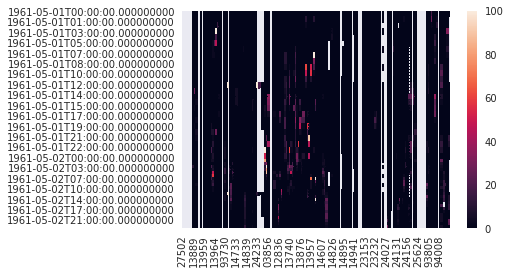

In [417]:
start_time = "1961-05-01 00:00:00"
end_time = "1961-10-31 23:00:00"

In [424]:
df_temp_all.ix[start_time:end_time, 0]

1961-05-01 00:00:00    NaN
1961-05-01 00:00:00    NaN
1961-05-01 00:00:00    NaN
1961-05-01 00:00:00    NaN
1961-05-01 01:00:00    NaN
1961-05-01 01:00:00    NaN
1961-05-01 01:00:00    NaN
1961-05-01 01:00:00    NaN
1961-05-01 02:00:00    NaN
1961-05-01 02:00:00    NaN
1961-05-01 02:00:00    NaN
1961-05-01 02:00:00    NaN
1961-05-01 03:00:00    NaN
1961-05-01 03:00:00    NaN
1961-05-01 03:00:00    NaN
1961-05-01 03:00:00    NaN
1961-05-01 04:00:00    NaN
1961-05-01 04:00:00    NaN
1961-05-01 04:00:00    NaN
1961-05-01 04:00:00    NaN
1961-05-01 05:00:00    NaN
1961-05-01 05:00:00    NaN
1961-05-01 05:00:00    NaN
1961-05-01 05:00:00    NaN
1961-05-01 06:00:00    NaN
1961-05-01 06:00:00    NaN
1961-05-01 06:00:00    NaN
1961-05-01 06:00:00    NaN
1961-05-01 07:00:00    NaN
1961-05-01 07:00:00    NaN
                      ... 
1961-10-31 16:00:00   -1.7
1961-10-31 16:00:00   -1.7
1961-10-31 17:00:00   -1.1
1961-10-31 17:00:00   -1.1
1961-10-31 17:00:00   -1.1
1961-10-31 17:00:00   -1.1
1

In [419]:
df_temp_all.ix[start_time:end_time, 0]

1961-05-01 00:00:00    NaN
1961-05-01 00:00:00    NaN
1961-05-01 00:00:00    NaN
1961-05-01 00:00:00    NaN
1961-05-01 01:00:00    NaN
1961-05-01 01:00:00    NaN
1961-05-01 01:00:00    NaN
1961-05-01 01:00:00    NaN
1961-05-01 02:00:00    NaN
1961-05-01 02:00:00    NaN
1961-05-01 02:00:00    NaN
1961-05-01 02:00:00    NaN
1961-05-01 03:00:00    NaN
1961-05-01 03:00:00    NaN
1961-05-01 03:00:00    NaN
1961-05-01 03:00:00    NaN
1961-05-01 04:00:00    NaN
1961-05-01 04:00:00    NaN
1961-05-01 04:00:00    NaN
1961-05-01 04:00:00    NaN
1961-05-01 05:00:00    NaN
1961-05-01 05:00:00    NaN
1961-05-01 05:00:00    NaN
1961-05-01 05:00:00    NaN
1961-05-01 06:00:00    NaN
1961-05-01 06:00:00    NaN
1961-05-01 06:00:00    NaN
1961-05-01 06:00:00    NaN
1961-05-01 07:00:00    NaN
1961-05-01 07:00:00    NaN
                      ... 
1961-10-31 16:00:00   -1.7
1961-10-31 16:00:00   -1.7
1961-10-31 17:00:00   -1.1
1961-10-31 17:00:00   -1.1
1961-10-31 17:00:00   -1.1
1961-10-31 17:00:00   -1.1
1

### Reading in and processing solrad data (NASA ISH_NSRD)

#### Step 1: read in solar radiation data


### Merging all data required for the input weather file into xr.Dataset 
- Date: in the form of datetime64
- SolRad: Wh/m2 (the solar radiation unit we have)
- Temp (˚C)
- Dew point temp (˚C)
- rain (mm)
- RH (%): need to be calculated from Temp & Dew Temp
- CO2 (ppm)

### Output all the information as a NetCDF file